In [1]:
import numpy as np
import scipy.optimize as sp
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
import juliandate as jd

In [2]:
df = pd.read_csv('Master_Data.csv')

Text(0, 0.5, 'Flux')

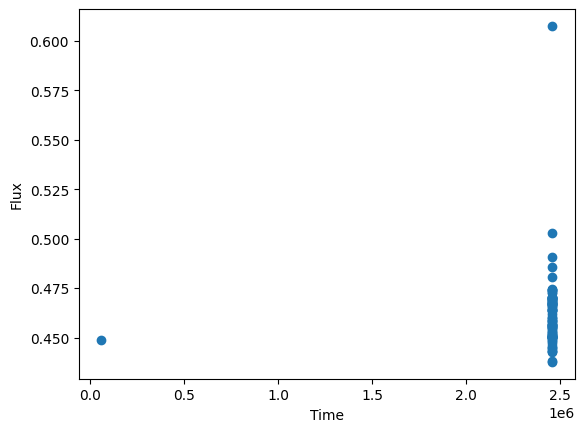

In [7]:
time = df['JD_UTC']
flux = df['av_rel_flux T1']
error = df['std_T1']

plt.scatter(time, flux)
#plt.xlim(2.45e6,2.46e6)
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

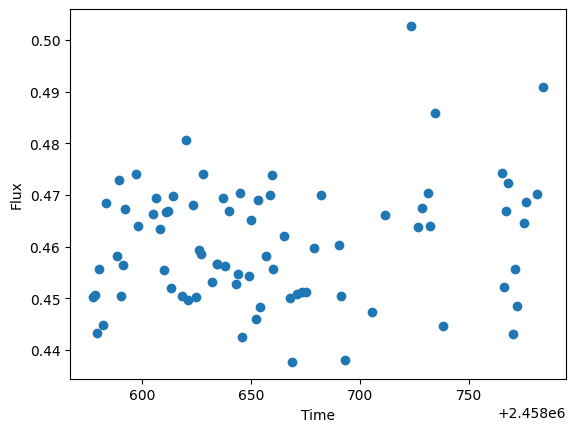

In [8]:
# CLEANED DATA SET

dropped = df.drop([30,63]) # use this one
dropped.where(df['JD_UTC'] < 2.4e6).dropna()

d_time = dropped['JD_UTC'] # time
d_flux = dropped['av_rel_flux T1'] # signal
d_error = dropped['std_T1']
plt.scatter(d_time, d_flux)
plt.xlabel('Time')
plt.ylabel('Flux')


In [17]:
# ROBERT QUIMBY VIDEO - MANUAL METHOD


t_man = dropped['JD_UTC'] 
flux_man = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1'])
error_man = dropped['std_T1']

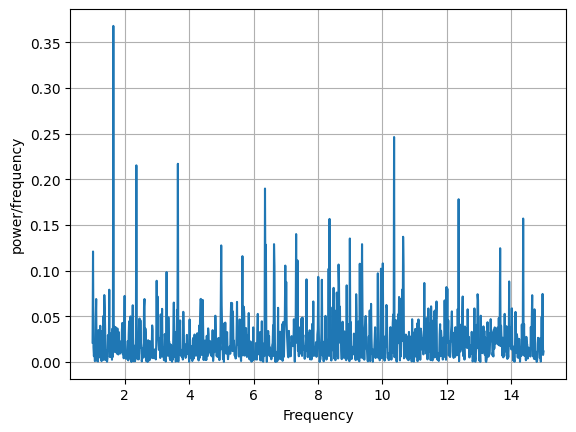

In [20]:
def get_model(params, freq, times):
    A, phi = params
    return A * np.cos(2 * np.pi * freq * times + phi)

def get_chisq(params, times, freq, values):
    model = get_model(params, freq, times)
    return np.sum((values - model)**2)
    
freqs = np.linspace(1, 15, 1000)
Y = np.matrix([[value] for value in signal])
A2, chisq = [], []

for freq in freqs:
    thetas = 2 * np.pi * freq * t_man
    X = np.matrix([[np.cos(theta), np.sin(theta)]for theta in thetas])
    p = (X.T * X).I * (X.T * Y)
    B, C = p.A1
    A = B/np.abs(B) * np.hypot(B,C)
    A2.append(A**2)
    phi = np.arctan(-C/B)
    chisq.append(get_chisq((A, phi), t_man, freq, flux_man))
chisq = np.array(chisq)
A2 = np.array(A2)
chisq0 = np.sum((signal - np.mean(signal))**2)
P = (chisq0 - chisq)/chisq0

plt.plot(freqs, P)
plt.xlabel("Frequency")
plt.ylabel("power/frequency")
plt.grid();

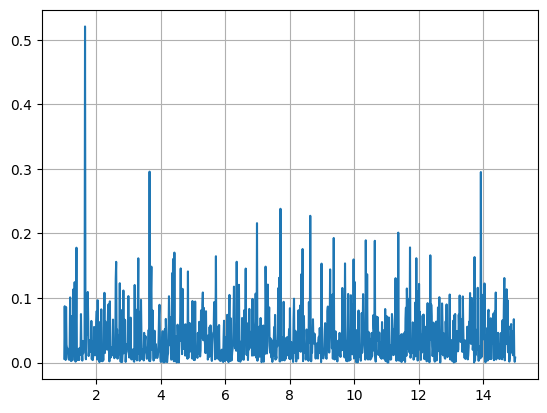

In [22]:
# ROBERT QUIMBY VIDEO - ASTROPY METHOD

t_astro = dropped['JD_UTC'] * u.day
mags = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1']) * u.mag
ls = LombScargle(t_astro, mags, d_error)
power = ls.power(freqs)

plt.plot(freqs, power)
plt.grid();

In [23]:
max_power = power[power == max(power)]
max_power_index = np.where(power == max_power)[0]
best_fit_period = freqs[max_power_index]
print(best_fit_period)

[1.64464464]


In [34]:
paper_period_index = np.where(freqs < 5.6 and freqs > 5.59)[0]
print(paper_period_index)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
print(freqs)

[ 1.          1.01401401  1.02802803  1.04204204  1.05605606  1.07007007
  1.08408408  1.0980981   1.11211211  1.12612613  1.14014014  1.15415415
  1.16816817  1.18218218  1.1961962   1.21021021  1.22422422  1.23823824
  1.25225225  1.26626627  1.28028028  1.29429429  1.30830831  1.32232232
  1.33633634  1.35035035  1.36436436  1.37837838  1.39239239  1.40640641
  1.42042042  1.43443443  1.44844845  1.46246246  1.47647648  1.49049049
  1.5045045   1.51851852  1.53253253  1.54654655  1.56056056  1.57457457
  1.58858859  1.6026026   1.61661662  1.63063063  1.64464464  1.65865866
  1.67267267  1.68668669  1.7007007   1.71471471  1.72872873  1.74274274
  1.75675676  1.77077077  1.78478478  1.7987988   1.81281281  1.82682683
  1.84084084  1.85485485  1.86886887  1.88288288  1.8968969   1.91091091
  1.92492492  1.93893894  1.95295295  1.96696697  1.98098098  1.99499499
  2.00900901  2.02302302  2.03703704  2.05105105  2.06506507  2.07907908
  2.09309309  2.10710711  2.12112112  2.13513514  2